In [5]:
import wave 
import pyaudio
import numpy as np 
import threading 
import matplotlib.pyplot as plt
import time 
from scipy.fftpack import fft

In [6]:
def find_closest_index(f, fs, fft_len):
    return int(round((f/(fs/2))*fft_len))

def triangular_filters(fft_len, fs, cb, freq):
    #print(freq)
    # rows - no. filters
    # columns - filter length
    Hb = np.zeros([len(cb) - 2, fft_len]) # len(cb) - 2 because 0th and last index are filter boundaries

    # calculate filters 
    for i in range(1, len(cb)-1):
        m = find_closest_index(cb[i-1], fs, fft_len)
        l = find_closest_index(cb[i], fs, fft_len)
        k = find_closest_index(cb[i+1], fs, fft_len)
        j = m
        
        while(freq[j] <= freq[k]):
            if freq[j] <= cb[i]:
                Hb[i-2][j] = (freq[j] - freq[m])/(freq[l]-freq[m])
            else:
                Hb[i-2][j] = (freq[k]-freq[j])  /  (freq[k]-freq[l])
            j += 1 

    plt.plot(Hb.T)
    plt.show()
    
    return Hb


def get_f0_cands():
    
    # constants.f0index = find(constants.freq <= 1500 & constants.freq >= 60);
    # constants.f0cands = constants.freq(constants.f0index);
    # Create actual candidate notes (http://www.phy.mtu.edu/~suits/NoteFreqCalcs.html)
    
    n  = np.arange(1,(5*12)+1)-1  #Five octaves of candidate notes. Use half step to get out of tune freqs
    f0 = 55.0         #Hz, A three octaves below A above the middle C
    a  = 2.0**(1.0/12.0) 
    freqs =  f0*(a**n)
    return freqs



#triangular_filters(512, 16000)
#print(get_f0_cands())



In [7]:
class HarmonicAmplitudeSummation(object):
    
    def __init__(self, fft_len, fs):
        self.fft_len = fft_len                       # 2^12???
        self.fs = fs                                 # 44100
        self.freq = np.zeros(fft_len)                   # zero pad to signal 
        b = np.arange(0, fft_len)
        self.freq = b*fs/(2*fft_len)      # frequencies of each bin    
        self.sub_bands = np.arange(1,33)             # sub-bands . Center frequencies are index 1 (val = 2 ) through index 30 (val = 31)

        self.cb = 229.0*(10.0**(self.sub_bands/21.4) - 1)         # Calculate center frequency of sub-bands

        self.Hb = triangular_filters(fft_len, fs, self.cb, self.freq) # triangular bandpass filters 
        
        self.f0cands = get_f0_cands()                # Pre-calculate frequency bins to include for a specific f0 candidate
        
        self.half_bin_width = ((fs/2)/fft_len)/2     # half bin width 
         
        #Pre-calculate harmonic frequencies associated bins for each f0 candidate
        self.num_harmonics = 20                     
        f0_cands_freq_bins = []  
        for i in range(0, len(self.f0cands)):
            bin_indices = []
            for h in range (1, self.num_harmonics + 1):
                # consider expanding # of indices for harmonics 
                f = self.f0cands[i]*h
                if f < fs/2:
                    if i > 5 and i < len(self.f0cands) - 1:
                        low_f =  (self.f0cands[i-1]*h + f)/2.0 
                        high_f = (self.f0cands[i+1]*h + f)/2.0 
                    else:
                        low_f  = f - self.half_bin_width  
                        high_f = f + self.half_bin_width
                    low  = find_closest_index(low_f, fs, fft_len)
                    high = find_closest_index(high_f, fs, fft_len)
                    if high > 511:
                        high = 511
                    # consider making each harmonic and its associated indices into separate lists 
                    # beacuse the paper uses the max of each harmonic 
                    bin_indices.append(range(low, high + 1))
                
            f0_cands_freq_bins.append(bin_indices)
            
        self.f0_cands_freq_bins = np.array(f0_cands_freq_bins)

        #print(self.f0_cands_freq_bins)
        # scaling coefficients
#         self.alpha = 52.0 
#         self.beta = 320.0  
#         self.dee = 0.89
        self.alpha = 27.0
        self.beta = 320.0
        self.dee = 1.0



    # perform spectral whitening on input signal. Removes timbral characteristics from signal
    # data In is frequency domain data
    def whiten(self, dataIn):

        num_center_freqs = len(self.sub_bands) - 2
        whitened = np.zeros(len(dataIn))
        #Calculate standard deviations and bandwise compression coefficients for each band center frequency 
        stdb = np.zeros(num_center_freqs) # -2 because the 0th and last band index @ 26Hz and 6935 Hz are not center frequencies      
        gammab = np.zeros(num_center_freqs)
        for i in range(0, num_center_freqs):
            stdb[i] = (sum(self.Hb[i]*(dataIn**2))/self.fft_len)**0.5
            gammab[i] = stdb[i]**(0.33-1)

#         plt.figure()
#         plt.plot(gammab)
#         plt.title('gammab')
#         plt.show()
        
        #Interpolate gamma
        gamma = np.zeros(self.fft_len)
        #Set the compression coefficients below the first centre band and after the final
        first_band = find_closest_index(self.cb[1], self.fs, self.fft_len) # change hardcoding 
        last_band = find_closest_index(self.cb[30], self.fs, self.fft_len)
        gamma[:first_band + 1] = gammab[0]
        gamma[last_band:] = gammab[-1]

        # Interpolate between first_band and last_band. From cb[1] to cb[30] 
        for i in range(1, num_center_freqs): #  
            initF = find_closest_index(self.cb[i], self.fs, self.fft_len)
            endF =  find_closest_index(self.cb[i+1], self.fs, self.fft_len)
            vec = np.linspace(gammab[i-1],gammab[i],endF-initF+1)
            gamma[initF:endF+1] = np.linspace(gammab[i-1],gammab[i],endF-initF+1)

#         plt.plot(gamma)
#         plt.title('gamma')

        whitened = gamma*dataIn
        return whitened 

    
    def get_salience(self, whitened):
        salience = np.zeros(len(self.f0cands))
        for i in range (0, len(self.f0cands)):
            summa = 0
            f = self.f0cands[i]
            findices = self.f0_cands_freq_bins[i]
            # m is n-1th ha#rmonic  
          
            #print('findices', findices)
            for m in range(0, len(findices)):
                ###print('findices', findices[m])
                max_freq_amp = np.max(whitened[findices[m]])
                summa += ((f+self.alpha)/((m)*f+self.beta)*max_freq_amp)
            
            salience[i] = summa
            
#         #print(salience)
#         plt.figure()
#         plt.plot(salience)
#         plt.title('salience')
        return salience 
            
    def detect_f0s(self, whitened):
        F0s = []
        S = []
        S.append(0.0)
        
        #Begin extracting F0s
        smax = 0.0
        index = 0
        detected_f0s = 0
        
        # F0 detection
        resultsk = np.zeros(len(self.freq))
        salience = []
        summa = []
        
        # detect if f0 exists first 
        
        while S[-1] >= smax:
            #Calculating the salience function, not using algoirthm # 1
            salience = getSalience(whitened,constants);
            f0_index = np.argmax(salience);
            
            #Salience calculated
            detected_f0s += 1 
            F0s.append(self.freq[index])

            # Frequency cancellation of found frequency and its harmonics 
            # findices = self.f0candsFreqBins[index]
            # m is not correct in this case. m should be the the #th harmonic, 
            # m = np.arange(1, len(self.findices) + 1) 
            # weighted_spectrum = (self.freq[findices]+self.alpha)/(m*self.freq[findices]+self.beta)*whitened[findices]

            
            for j in range (1, self.num_harmonics + 1):
                if f0_index * j  < self.fft_len:    #  f0_index * j + 1 ? 
                    for i in range (-1,2):
                        resultsk[index*j+i] += (self.fs*self.freq[index*j+i]+alpha)/(j*self.fs*constants.freq[index*j+i]+beta)*whitened[index*j+i];
                    if (whitened[index*j+i]-resultsk[index*j+i] > 0):
                        whitened[index*j+i]= whitened[index*j+i]-resultsk[index*j+i]*self.dee;
                    else:
                        whitened[index*j+i]=0;

        
            # Later perform actual # polyphonic sound estimation
            #frequency cancellation done

            if len(S) < detected_f0s:
                S.append(0.0);

            summa = sum(resultsk)

            S[-1] = summa/(detected_f0s**0.7)
            if (S[-1] > smax):
                smax = S[-1]
            
            #Polyphony estimated
        
        #The last F0 is extra...
        print("Remove extra")
                        
        if (len(F0s) > 1):
            F0s = F0s[:-1]
        
        return F0s;


    def cancel_pitch(self, whitened,detected_freqs,index):
        #Frequency cancellation
        bins_to_cancel = self.f0_cands_freq_bins[index]
        for j in range (0, len(bins_to_cancel)): # or 1 to bins_to_cancel + 1
            
            #cancel adjacent bins as well
            
#             for k in range (-1, 2):
#                 print('bin', [bins_to_cancel[j]])
#                 detected_freqs[bins_to_cancel[j]+k] += ((self.freq[bins_to_cancel[j]+k]+self.alpha)/(j*self.freq[bins_to_cancel[j]+k]+self.beta))*whitened[bins_to_cancel[j]+k]
#                 whitened[bins_to_cancel[j] + k ] -= detected_freqs[bins_to_cancel[j]+k]*self.dee
            detected_freqs[bins_to_cancel[j]] += ((self.freq[bins_to_cancel[j]]+self.alpha)/(j*self.freq[bins_to_cancel[j]]+self.beta))*whitened[bins_to_cancel[j]]
            whitened[bins_to_cancel[j]] -= detected_freqs[bins_to_cancel[j]]*self.dee    
        
        whitened[whitened < 0 ] = 0 
        
        return whitened, detected_freqs


    
    
    def time_to_freq(self, signalIn):
        
        # Apply hann windowing
        hann_windowed = signalIn*np.hanning(len(signalIn))
        
        #Double the signal length by appending zeroes
        appended = np.pad(hann_windowed, (0, len(hann_windowed)), 'constant')
        fft_signal = fft(appended)
        #fft_signal= fft_signal./(len(fft_signal)/2+1)
        fft_signal[0] = fft_signal[0]/2;
        fft_amp = abs(fft_signal[0:self.fft_len]) #Ignore the second half of the fft

        whitened = self.whiten(fft_amp)
#         plt.figure()
#         plt.plot(fft_amp[0:127])
#         plt.title('fft' + str(np.argmax(fft_amp[0:127])))
#         plt.show()
#         plt.figure()
#         plt.plot(whitened)
#         plt.title('whitened fft')
#         plt.show()
        return whitened 
    
    
    
    def polyphonic_pitch_detect(self, signalIn):
        
        # calculate whitened FFT signal from time series data
        whitened = self.time_to_freq(signalIn)
        
        # Initialize found F0 list and their counts 
        F0s = []
        detected_f0s = 0
        
        # Initialize spectrum of detected F0s
        detected_freqs = np.zeros(self.fft_len)
        
        
        smax = 0;
        S = [];
        S.append(0)
       
        #Loop while smax is increasing

        while S[-1] >= smax:
            #Salience calculated
            detected_f0s += 1 
            
            salience = self.get_salience(whitened)
            f0_index = np.argmax(salience)
#             if salience[f0_index] < 400: 
#                 break
            print(salience[f0_index])
        
            whitened, detected_freqs = self.cancel_pitch(whitened,detected_freqs,f0_index)
            #estimate smax here
    
            sumDetected = np.sum(detected_freqs)
            v = sumDetected/(detected_f0s**0.7)
            #print(v)
            S.append(v)
            if S[-1] > smax:
                smax = S[-1]
                F0s.append(self.f0cands[f0_index])

        print(F0s)


In [8]:
class Listener(object):
    """
    The Listener  class is made to provide access to continuously recorded
    (and mathematically processed) microphone data.
    """

    def __init__(self,algorithm,chunk,rate,device=None,startStreaming=True, ):
      
        print(" -- initializing Listener")
        
        self.algorithm = algorithm
        self.chunk = chunk # number of data points to read at a time
        self.rate = rate # time resolution of the recording device (Hz)

        # for tape recording (continuous "tape" of recent audio)
        self.tapeLength=2 #seconds
        self.tape = np.zeros(self.rate*self.tapeLength)
        self.record = []
        
        self.p=pyaudio.PyAudio() # start the PyAudio class
        if startStreaming:
            self.stream_start()

    ### LOWEST LEVEL AUDIO ACCESS
    # pure access to microphone and stream operations
    # keep math, plotting, FFT, etc out of here.
    
    def stream_read(self):
        """return values for a single chunk"""
        audio_in = self.stream.read(self.chunk, exception_on_overflow = False)
        self.record.append(audio_in)
        data = np.fromstring(audio_in, dtype=np.int16)
        return data

    def stream_start(self):
        """connect to the audio device and start a stream"""
        print(" -- stream started")
        self.stream=self.p.open(format=pyaudio.paInt16,channels=1,
                                rate=self.rate,input=True,
                                frames_per_buffer=self.chunk)
                                #input_device_index = 0)

    def stream_stop(self):
        """close the stream but keep the PyAudio instance alive."""
        #if 'stream' in locals():
        self.stream.stop_stream()
        self.stream.close()
        print(" -- stream CLOSED")
        

    def close(self):
        """gently detach from things."""
        self.stream_stop()
        self.p.terminate()

    ### TAPE METHODS
    # tape is like a circular magnetic ribbon of tape that's continously
    # recorded and recorded over in a loop. self.tape contains this data.
    # the newest data is always at the end. Don't modify data on the type,
    # but rather do math on it (like FFT) as you read from it.

    def tape_add(self):
        """add a single chunk to the tape."""
        while True:

            self.tape[:-self.chunk]=self.tape[self.chunk:]
            self.tape[-self.chunk:]=self.stream_read()
            
            
            
    def tape_flush(self):
        """completely fill tape with new data."""
        readsInTape=int(self.rate*self.tapeLength/self.chunk)
        print(" -- flushing %d s tape with %dx%.2f ms reads"%\
                  (self.tapeLength,readsInTape,self.chunk/self.rate))
        for i in range(readsInTape):
            self.tape_add()

    def tape_plot(self,saveAs="03.png"):
        """plot what's in the tape."""
        pylab.plot(np.arange(len(self.tape))/self.rate,self.tape)
        pylab.axis([0,self.tapeLength,-2**16/2,2**16/2])
        pylab.show()
        print() #good for IPython
        #pylab.close('all')
        
    
        
    def realtime_analysis(self,duration = 10,  plotSec=.25):
        t1=0
       
        #try:
        #while True:
        
        th = threading.Thread (target = self.tape_add)
        th.start()
        
        time.sleep(1)
        
        for i in range(0, int(self.rate / self.chunk * duration)):
            
            start = time.time()
            self.algorithm.polyphonic_pitch_detect(self.tape[:-(3*self.chunk):-1])
            print('time elapsed:', time.time() - start)
             
#         except:
#             print(" ~~ exception (keyboard?)")


        return

    def export_wav(self, filename, rate):
            
        # output recorded 
        waveFile = wave.open(filename, 'wb')
        waveFile.setnchannels(1)
        waveFile.setsampwidth(audio_port.p.get_sample_size(pyaudio.paInt16))
        waveFile.setframerate(rate)
        waveFile.writeframes(b''.join(audio_port.record))
        waveFile.close()
            


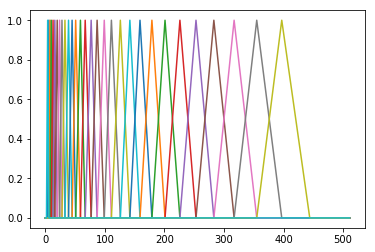

 -- initializing Listener
 -- stream started
689.222935985
448.167890134
[1396.9129257320189]
time elapsed: 0.0350039005279541
689.222935985
448.167890134
[1396.9129257320189]
time elapsed: 0.032273292541503906
412.765858359
380.884651569
326.321080048
315.184902144
295.342537376
[1046.5022612023968, 1318.5102276514829, 1479.9776908465412, 1396.9129257320189]
time elapsed: 0.0904378890991211
352.133849497
313.366713499
197.204012536
189.450714889
180.265602476
170.31191223
167.483787164
150.04119864
130.918445706
[698.45646286600913, 659.25511382574109, 1479.9776908465412, 1108.7305239074908, 1174.659071669633, 1046.5022612023968, 1244.5079348883264, 1567.9817439270009]
time elapsed: 0.156951904296875
358.99298167
260.029813282
259.393503101
204.439500555
[1046.5022612023968, 1244.5079348883264, 1396.9129257320189]
time elapsed: 0.0626068115234375
328.566895971
315.190023584
261.760518485
225.598205693
[1318.5102276514829, 1046.5022612023968, 830.60939515989196]
time elapsed: 0.0663309

KeyboardInterrupt: 

In [9]:
%reload_ext autoreload

if __name__ =="__main__":
    
    %autoreload
    buffer_len = 512
    pitch = 0 
    fs = 16000
    has = HarmonicAmplitudeSummation(buffer_len, fs)
    chunk = 512
    
    # listener init 
    audio_port = Listener(has, chunk, fs)

    # listen and analyze 
    audio_port.realtime_analysis()
    
    audio_port.export_wav("Test.wav", fs)
    audio_port.close()

